**Imports**

In [95]:
from imports import * 
from functions import *
from archs import *
from mylearner import *
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Loading annotated data**

In [96]:
from loading_data import *

**Encode target classes (person and window open) classes**

In [97]:
df1 = encode_classes(d1)
df2 = encode_classes(d2)
df = encode_classes(data)

0    18144
1     1440
2      139
4        2
3        1
Name: person, dtype: int64
0    18701
1     1025
Name: window_open, dtype: int64
(19726, 23)
0    43791
1      604
2       50
Name: person, dtype: int64
0    44156
1      289
Name: window_open, dtype: int64
(44445, 23)
0    61935
1     2044
2      189
4        2
3        1
Name: person, dtype: int64
0    62857
1     1314
Name: window_open, dtype: int64
(64171, 23)


**select some columns to plot**

[Text(0, 0, '1314'),
 Text(0, 0, '62857'),
 Text(0, 0, '61935'),
 Text(0, 0, '2044'),
 Text(0, 0, '189'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

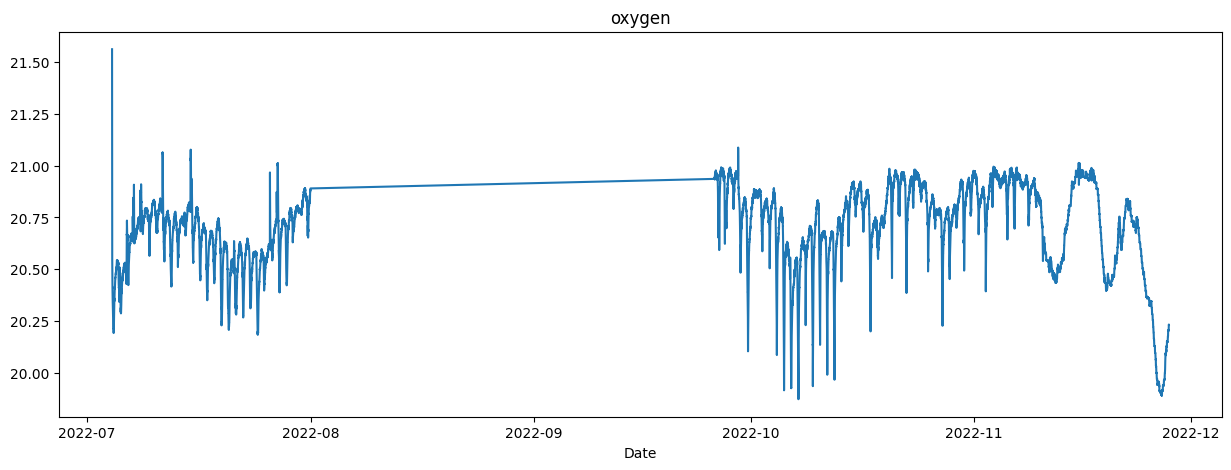

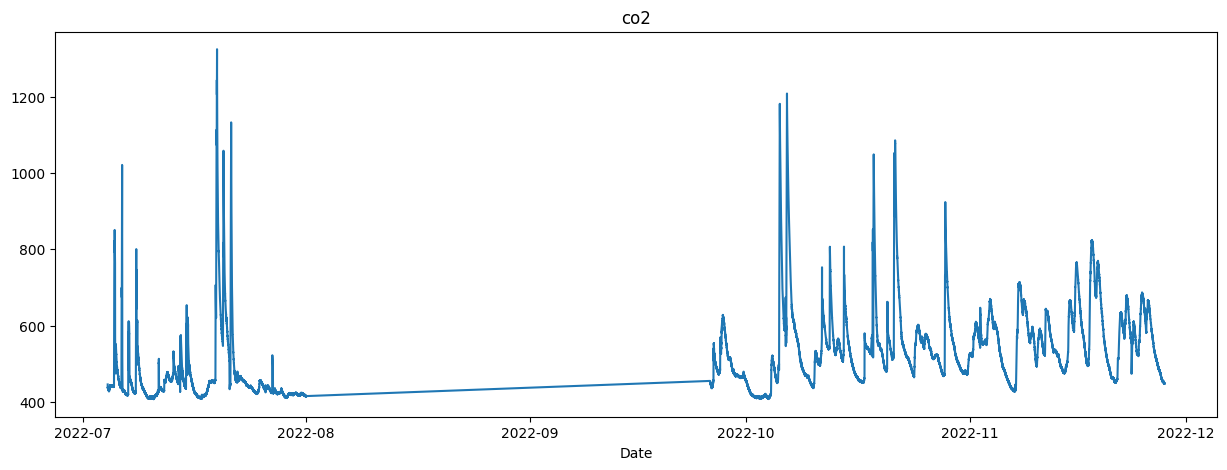

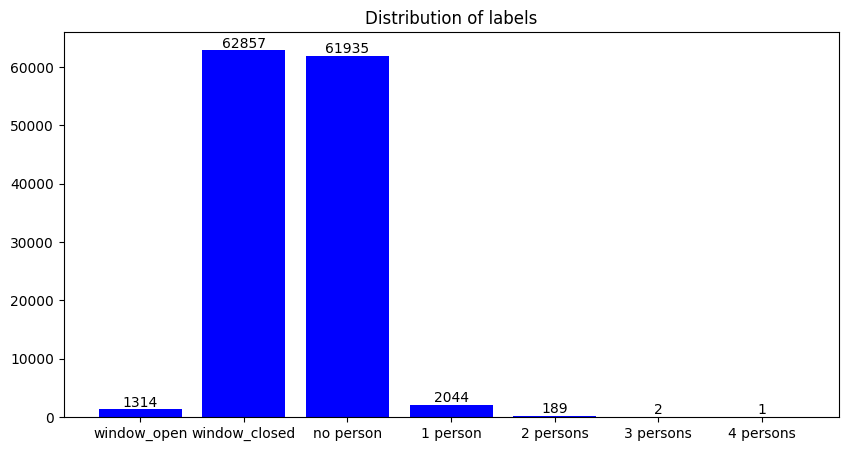

In [98]:
plot_cols = ['oxygen', 'co2','person','window_open']

x = df.datetime

# plot o2 and co2 
for col in plot_cols[0:2]:
    fig = plt.figure(figsize=(15,5))
    plt.plot(x, df[col])
    plt.xlabel('Date')
    plt.title(col)

#plot distribution of number of persons and window open

x_lbs = ['window_open','window_closed','no person','1 person','2 persons','3 persons','4 persons']
y_nmrs = [df['window_open'].value_counts()[1],df['window_open'].value_counts()[0],df['person'].value_counts()[0],df['person'].value_counts()[1],df['person'].value_counts()[2],df['person'].value_counts()[4],df['person'].value_counts()[3]]

fig, ax = plt.subplots(figsize=(10,5))    
ind = np.arange(len(y_nmrs))  # the x locations for the groups
bars = ax.bar(ind, y_nmrs, color="blue")
ax.set_xticks(ind)
ax.set_xticklabels(x_lbs, minor=False)
plt.title('Distribution of labels')
# plt.grid(linestyle = '--')
# plt.xlabel('x')
# plt.ylabel('y')
ax.bar_label(bars)



# for col in plot_cols[2:]:
#     fig = plt.figure()
#     plt.hist(df[col],label='Test set distribution')
#     plt.xlabel(f'\n {col}')
# ## Ticks labels - List must be in ascending order
#     plt.xticks(df[col].unique()) ### names of classes starting from 0
#     #sns.distplot(df[col], bins=100, kde=False)
#     plt.title(f'Distribution of {col}')
#     plt.legend()
#     plt.show()
#     # plt.figure()
#     # df[col].value_counts().plot.pie(autopct='%0.2f')



**plot scaled data in one figure**

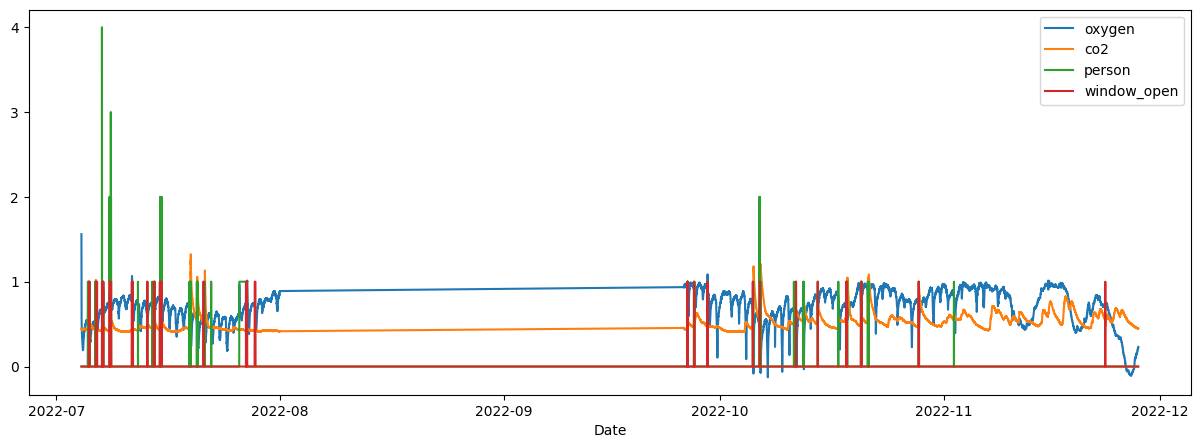

In [99]:
x = df.datetime
fig = plt.figure(figsize=(15,5))

plt.xlabel('Date')
plt.plot(x, df['oxygen']-20,label='oxygen')
plt.plot(x, df['co2']/1000,label='co2')
plt.plot(x, df['person'],label='person')
plt.plot(x, df['window_open'], label='window_open' )
plt.legend()


**filtering data**

In [100]:
# h2s column has only NaN values, also drop timestamp,datetime,deviceid
df.drop(columns=['h2s','timestamp','deviceid'],inplace=True)
df1.drop(columns=['h2s','timestamp','deviceid'],inplace=True)
df2.drop(columns=['h2s','timestamp','deviceid'],inplace=True)

**Missing values, drop NAN**

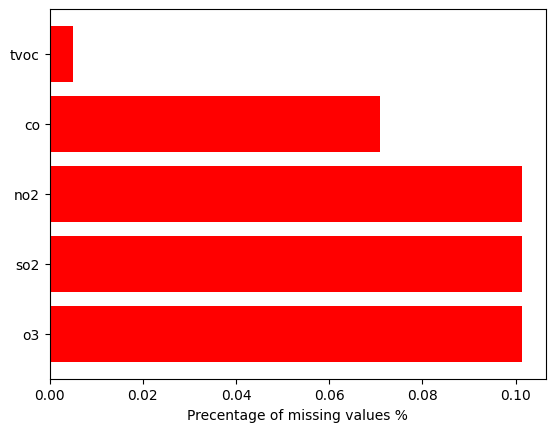

maximum number of missing values per column=  20 

   column  count  percentage
12     o3     20    0.101389
5     so2     20    0.101389
6     no2     20    0.101389
2      co     14    0.070972
9    tvoc      1    0.005069


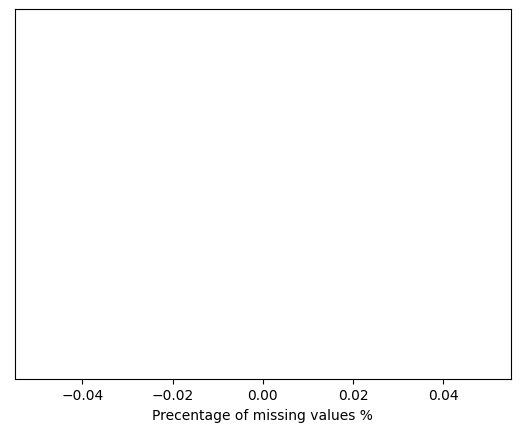

maximum number of missing values per column=  nan 

Empty DataFrame
Columns: [column, count, percentage]
Index: []


In [101]:
plot_missing(df1)
plot_missing(df2)

#### substitute NaN values with mean 
## polynomial interpolation with degree > 1 uses index, also convert dtype to float to work
df1 = impute_NaN(df1)
df2 = impute_NaN(df2)
############## conmbine into df 

df = concat(df1,df2)
# df.reset_index(drop=True,inplace= True)
df.columns=df1.columns

### drop datetime column and store it before for visualization
datetime_df = df.datetime
datetime_df1 = df1.datetime
datetime_df2 = df2.datetime

df.drop(columns=['datetime'],inplace=True)
df1.drop(columns=['datetime'],inplace=True)
df2.drop(columns=['datetime'],inplace=True)



**minimized dataset for our classification task, drop  rows for testing**

In [102]:

print(df['person'].value_counts(),'\n',df['window_open'].value_counts(),'\n')

#### combine classes of more than 1 person to 1 person as there exists too little of them
lc = df.loc[lambda x: x['person'] > 1]
df.loc[lc.index,'person'] = 1

lc = df1.loc[lambda x: x['person'] > 1]
df1.loc[lc.index,'person'] = 1

lc = df2.loc[lambda x: x['person'] > 1]
df2.loc[lc.index,'person'] = 1

print(df['person'].value_counts(),'\n',df['window_open'].value_counts(),'\n')


############### drop  rows for testing
### november (one month) for testing
df2_test = df2.iloc[df2.shape[0]-22000:df2.shape[0]-21700] ## to get better visualization on less focused data
datetime_test = datetime_df2.iloc[datetime_df2.shape[0]-22000:datetime_df2.shape[0]-21700]
df2 = df2.drop(index = df2.index[df2.shape[0]-22000:]) ### to keep the sequence order drop from last
datetime_df2 = datetime_df2.drop(index = datetime_df2.index[datetime_df2.shape[0]-22000:])

### end of september (~ 10 days ) for testing
# df2_test = df2.iloc[7300:7500]## to get better visualization on less focused data
# datetime_test = datetime_df2.iloc[7300:7500]
# df2 = df2.drop(index = df2.index[:7500]) ### to keep the sequence order drop from last
# datetime_df2 = datetime_df2.drop(index = datetime_df2.index[:7500])

### end of August (~ 5 days ) for testing
# df1_test = df1.iloc[df1.shape[0]-3500:df1.shape[0]-3200]## to get better visualization on less focused data
# df1 = df1.drop(index = df1.index[df1.shape[0]-3500:]) ### to keep the sequence order drop from last


### first of July (~ 1-2 days ) for testing
# df1_test = df1.iloc[600:800]## to get better visualization on less focused data
# df1 = df1.drop(index = df1.index[:800]) ### to keep the sequence order drop from last

### for visualization
datetime_train = concat(datetime_df1,datetime_df2)
df_train = concat(df1,df2)
df_train.columns=df1.columns

# df2.reset_index(drop=True,inplace=True)
# df2_test.reset_index(drop=True,inplace=True)

df2_test_targets = df2_test.filter(['person','window_open'])
df2_test_features = df2_test.drop(columns=['person','window_open']) 


# #### remove rows with 3 (one row) and 4 person (2 rows)
# lc = df.loc[lambda x: x['person'] == 3]
# df.drop(lc.index,inplace=True)

# lc = df.loc[lambda x: x['person'] == 4]
# df.drop(lc.index,inplace=True)

# df['person'].value_counts(),df['window_open'].value_counts()



targets = df.filter(['person','window_open'])
features = df.drop(columns=['person','window_open']) 


targets1 = df1.filter(['person','window_open'])
features1 = df1.drop(columns=['person','window_open']) 

targets2 = df2.filter(['person','window_open'])
features2 = df2.drop(columns=['person','window_open']) 



### minimized data
l_ = ['humidity','temperature','tvoc','oxygen','co2','co','pressure','o3','sound','person','window_open']
f_ = ['humidity','temperature','tvoc','oxygen','co2','co','pressure','o3','sound']
### from leipzig data
# l_ = ['humidity_abs','temperature','tvoc','oxygen','co2','co','no2','o3','person','window_open']
# f_ = ['humidity_abs','temperature','tvoc','oxygen','co2','co','no2','o3']

df_mini1 = df1.filter(l_)
print(df_mini1.shape,'\n',df_mini1['person'].value_counts(),'\n',df_mini1['window_open'].value_counts(),'\n')
features_mini1 = features1.filter(f_)
# print(targets1.iloc[:,0].value_counts())

df_mini2 = df2.filter(l_)
print(df_mini2.shape,'\n',df_mini2['person'].value_counts(),'\n',df_mini2['window_open'].value_counts(),'\n')
features_mini2 = features2.filter(f_)
# print(targets2.iloc[:,0].value_counts())

df2_test_mini = df2_test.filter(l_)
print(df2_test_mini.shape,'\n',df2_test_mini['person'].value_counts(),'\n',df2_test_mini['window_open'].value_counts(),'\n')
df2_test_features_mini = df2_test_features.filter(f_)

## whole df
df_mini = df.filter(l_)
print(df_mini.shape,'\n',df_mini['person'].value_counts(),'\n',df_mini['window_open'].value_counts(),'\n')
features_mini = features.filter(f_)
# print(targets2.iloc[:,0].value_counts())


0    61915
1     2044
2      189
4        2
3        1
Name: person, dtype: int64 
 0    62837
1     1314
Name: window_open, dtype: int64 

0    61915
1     2236
Name: person, dtype: int64 
 0    62837
1     1314
Name: window_open, dtype: int64 

(19706, 11) 
 0    18124
1     1582
Name: person, dtype: int64 
 0    18681
1     1025
Name: window_open, dtype: int64 

(22445, 11) 
 0    21852
1      593
Name: person, dtype: int64 
 0    22206
1      239
Name: window_open, dtype: int64 

(300, 11) 
 0    245
1     55
Name: person, dtype: int64 
 0    259
1     41
Name: window_open, dtype: int64 

(64151, 11) 
 0    61915
1     2236
Name: person, dtype: int64 
 0    62837
1     1314
Name: window_open, dtype: int64 



**Correlation Matrix, drop highly correlated features**

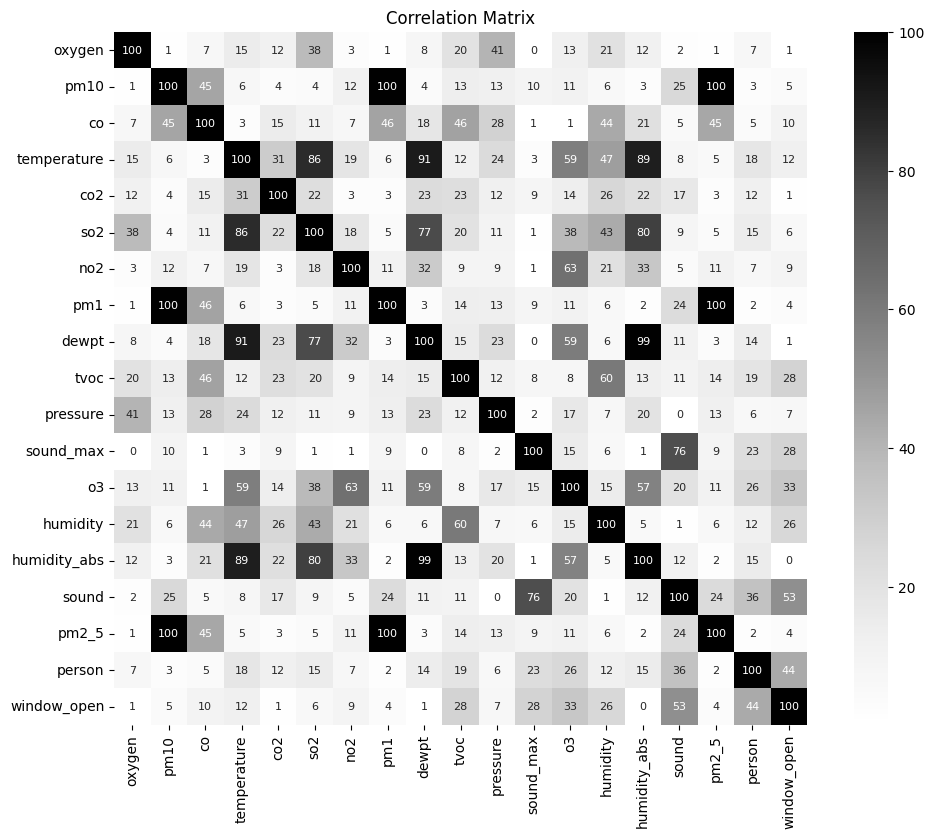

In [103]:
corr = df.corr(min_periods=1000)
high_corr = np.abs(corr)*100
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(high_corr, cbar=True,annot=True, square=True, fmt='.0f', 
            annot_kws={'size': 8},cmap='Greys')
plt.title('Correlation Matrix')
plt.show()

##### drop 99%-100% correlated features

# remove_list = ['pm10','pm2_5','dewpt']
# features.drop(columns=remove_list,inplace=True)
# features1.drop(columns=remove_list,inplace=True)
# features2.drop(columns=remove_list,inplace=True)
# df1.drop(columns=remove_list,inplace=True)
# df2.drop(columns=remove_list,inplace=True)

# ### for different test set
# df2_test_features.drop(columns=remove_list,inplace=True)
# df2_test.drop(columns=remove_list,inplace=True)
################################3

# corr = features.corr(min_periods=1000)
# high_corr = np.abs(corr)*100
# f, ax = plt.subplots(figsize=(19,14))
# sns.heatmap(high_corr, cbar=True,annot=True, square=True, fmt='.0f', 
#             annot_kws={'size': 8},cmap='Greys')
# plt.title('Correlation Matrix after removing highly correlated features')
# plt.show()


**test Standardization function**

In [104]:
# t = np.array([[[1,2],[3,7]],[[5,6],[7,8]],[[5,6],[7,8]]])
# xt = np.empty(t.shape)
# scalers = {}
# for i in range(t.shape[1]):
#     scalers[i] = StandardScaler()
#     scalers[i].fit(np.unique(t[:, i, :]).reshape(-1,1)) ### as we have overlapping samples
#     xt[:, i, :] = scalers[i].transform(t[:, i, :].reshape(-1,1)).reshape(t.shape[0],t.shape[-1])

# xx,p1,p2 = standardize(t,mode=1)


In [105]:
# ### test standardize
# t = np.array([[[1,2],[3,7]],[[5,6],[7,8]],[[5,6],[7,8]]])
# sh = t.shape
# print(t)
# # print(t - np.array([1,0]).reshape(1,2,1))
# mean = [1,0]
# std = [2,1]
# tt,p1,p2 = standardize(t,mode=2)
# print(tt,p1,p2)
# # print(standardize_with_params(t,mean=p1,std=p2)==tt)

**test sliding over data**

In [106]:
# ### testing sliding
# from functions import *
# _features = pd.DataFrame({'x': [0,1,2,3,4,5,6,7,8,9],'z': [10,11,12,13,14,15,16,17,18,19]})
# _targets = pd.DataFrame({'person': [0,0,1,1,1,0,1,1,0,0],'window_open': [0,1,1,0,1,0,1,0,1,1]}) 
# df3 = pd.concat([_features,_targets],axis=1)
# print(df3)
# # _x,_y= SlidingWindow(3,2,get_x=[0,1],get_y=[2,3],horizon = 0)(df3)
# _x,_y = sliding(3,2,_features,_targets,mode='end')
# print(_x.shape,_y.shape,_x,_y)

**test underSampling**

In [107]:
# ### testing undersampling
# test = pd.DataFrame([[1,2,0,0],[3,4,0,1],[5,6,0,0],[7,8,1,1],[9,10,0,0],[11,12,0,0],[13,14,0,0],[15,16,1,0],[15,16,1,0]],columns=['x','y','person','window_open'])
# print(test)
# t = test.filter(['person','window_open'])
# f = test.drop(columns = ['person','window_open'])
# X,y=under_sample(test,2,2,1)
# print(X.shape,y.shape,'\n',X,y)
# # print(X,y)
# print(X.shape,y.shape)


**Perform undersampling and segmentation**

read yaml config file

In [108]:
with open('config.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)

under sample and segment

In [109]:
under_window = hyperparams['sample_segment']['under_window']
seq_len = hyperparams['sample_segment']['seq_len']
stride = hyperparams['sample_segment']['stride']
sliding_mode = hyperparams['sample_segment']['sliding_mode']
all_features = hyperparams['sample_segment']['all_features']

# standard_mode = 1 ## 1=normalizec, 2= minmax

# reset index 
# df_mini.reset_index(drop=True)
# features_mini.reset_index(drop=True)
# targets.reset_index(drop=True)
#t = df_mini.values
#X, y = SlidingWindow(window_len=window , stride = stride, get_x = [0,1], get_y = [2])(df_mini)

## undersampling and sliding
sampling = hyperparams['sample_segment']['sampling']
if sampling:
    if all_features:
        X1,y1= under_sample(df1,under_window,seq_len,stride,sliding_mode=sliding_mode)
        X2,y2= under_sample(df2,under_window,seq_len,stride,sliding_mode=sliding_mode)
    else:
        X1,y1= under_sample(df_mini1,under_window,seq_len,stride,sliding_mode=sliding_mode)
        X2,y2= under_sample(df_mini2,under_window,seq_len,stride,sliding_mode=sliding_mode)
else:
    if all_features:
        X1,y1= sliding(seq_len,stride,features1,targets1,mode=sliding_mode)
        X2,y2= sliding(seq_len,stride,features2,targets2,mode=sliding_mode)
    else:
        X1,y1= sliding(seq_len,stride,features_mini1,targets1,mode=sliding_mode)
        X2,y2= sliding(seq_len,stride,features_mini2,targets2,mode=sliding_mode)


### standardizing segments after undersampling

# mean,std from dataset after undersampling
# X1_ = standardize_with_params(X1,mean = mean1, std = std1)
# X2_ = standardize_with_params(X2,mean = mean1, std = std2)

# mean,std from dataset before undersampling
# X1_ = standardize_with_params(X1,min = features_mini1.min(axis=0), max = features_mini1.max(axis=0))
# X2_ = standardize_with_params(X2,min = features_mini2.min(axis=0), max = features_mini2.max(axis=0))


##################################################################################################
# # standardize the whole data without undersampling

# features_mini1 = standardize_with_params(features_mini1,mean = features_mini1.mean(axis=0),std = features_mini1.std(axis=0))
# features_mini2 = standardize_with_params(features_mini2,mean = features_mini2.mean(axis=0),std = features_mini2.std(axis=0))

# ## sliding the whole data
# X1_,y1 = sliding(seq_len,stride,features_mini1,targets1)#.loc[:,'person'])
# X2_,y2 = sliding(seq_len,stride,features_mini2,targets2)#.loc[:,'person'])

X = concat(X1,X2)
# X = concat(X1_,X2_)
y = concat(y1,y2)
X.shape, y.shape


((5054, 9, 7), (5054, 2))

**splitting sets and standardization**

**using sklearn**

In [110]:
###### splitting
# splits = TrainValidTestSplitter(valid_size=0.2,test_size=0.1)(y) ##### we have test set here
splits = TrainValidTestSplitter(valid_size=0.1)(y) ##### we DON'T have test set here
x_train = np.zeros(X[splits[0]].shape,dtype=np.float32)
y_train = y[splits[0]]
x_valid = np.zeros(X[splits[1]].shape,dtype=np.float32)
y_valid = y[splits[1]]
# x_test = np.zeros(X[splits[2]].shape,dtype=np.float32)
# y_test = y[splits[2]]

#different test set
### uses stride = 1 to check all time points
if all_features:
    x_test_, y_test = sliding(seq_len,1,df2_test_features,df2_test_targets,mode=sliding_mode)
else:
    x_test_, y_test = sliding(seq_len,1,df2_test_features_mini,df2_test_targets,mode=sliding_mode)
x_test = np.zeros(x_test_.shape,dtype=np.float32) 
#################



#### standardization
scalers = {}
for i in range(x_train.shape[1]): ## n_features
    scalers[i] = StandardScaler()
    scalers[i].fit(np.unique((X[splits[0]])[:, i, :]).reshape(-1,1)) ### as we have overlapping samples
    x_train[:, i, :] = scalers[i].transform((X[splits[0]])[:, i, :].reshape(-1,1)).reshape(x_train.shape[0],x_train.shape[-1])
    x_valid[:, i, :] = scalers[i].transform((X[splits[1]])[:, i, :].reshape(-1,1)).reshape(x_valid.shape[0],x_valid.shape[-1])
    # x_test[:, i, :] = scalers[i].transform((X[splits[2]])[:, i, :].reshape(-1,1)).reshape(x_test.shape[0],x_test.shape[-1]) ## from splitting
    x_test[:, i, :] = scalers[i].transform((x_test_)[:, i, :].reshape(-1,1)).reshape(x_test.shape[0],x_test.shape[-1]) ## test set from outside
print(x_train.shape,x_valid.shape,x_test.shape)

(4549, 9, 7) (505, 9, 7) (294, 9, 7)


**for visualizing train and test sets**

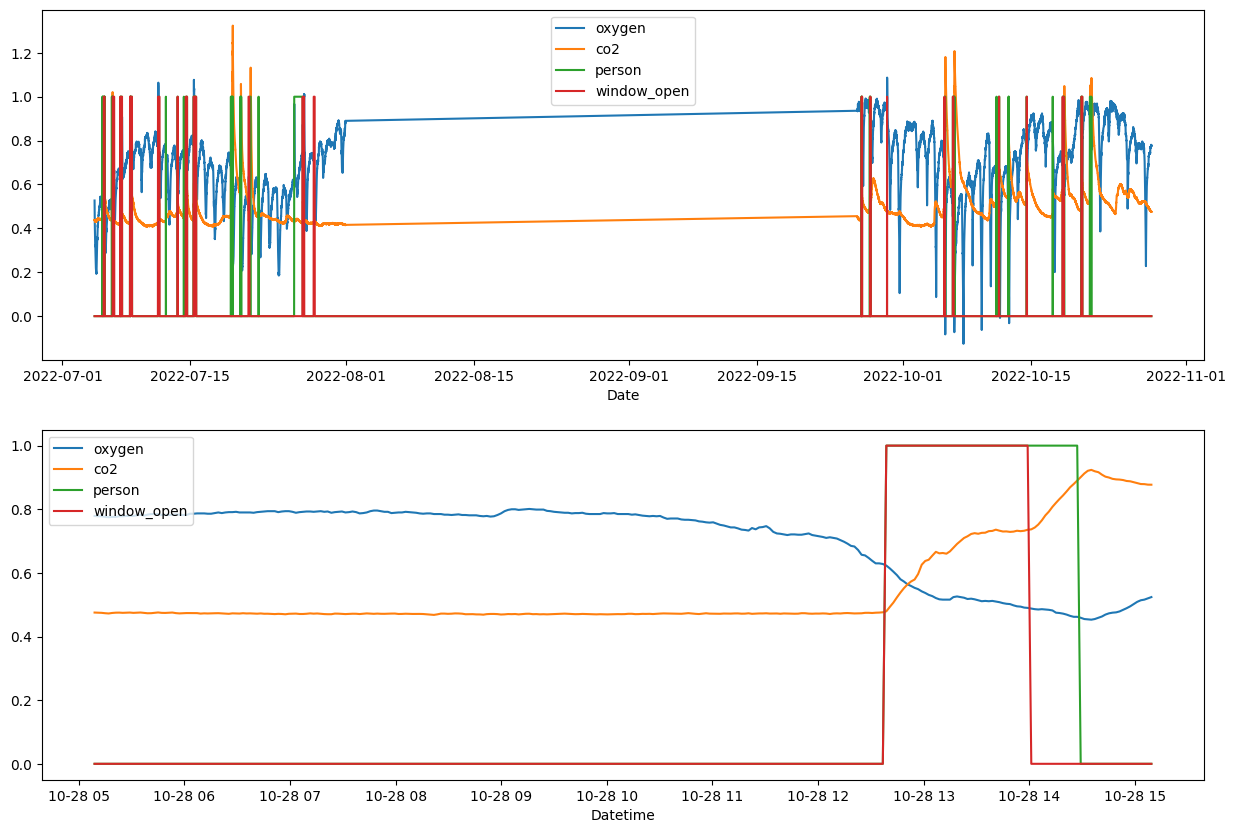

In [111]:

### for train set
x = datetime_train
# fig = plt.figure(figsize=(15,5))
fig, (ax2,ax1) = plt.subplots(2,1,figsize=(15,10))    
ax2.set_xlabel('Date')
ax2.plot(x, df_train['oxygen']-20,label='oxygen')
ax2.plot(x, df_train['co2']/1000,label='co2')
ax2.plot(x, df_train['person'],label='person')
ax2.plot(x, df_train['window_open'], label='window_open' )
# plt.plot(x, test_preds_unannotated[:,0],label='person')
# plt.plot(x, test_preds_unannotated[:,1], label='window_open' )
ax2.legend()

### for test set
### if x_test shape after segmentation is used for prediction
# n_seq = x_test.shape[0]
# x = datetime_test.iloc[0:n_seq]
# df_cropped = df2_test.iloc[0:n_seq]
x = datetime_test
# fig = plt.figure(figsize=(15,5))
ax1.set_xlabel('Datetime')
ax1.plot(x, df2_test['oxygen']-20,label='oxygen')
ax1.plot(x, df2_test['co2']/1000,label='co2')
ax1.plot(x, df2_test['person'],label='person')
ax1.plot(x, df2_test['window_open'], label='window_open' )
# plt.plot(x, df_cropped['oxygen']-20,label='oxygen')
# plt.plot(x, df_cropped['co2']/1000,label='co2')
# plt.plot(x, test_preds_unannotated[:,0],label='person')
# plt.plot(x, test_preds_unannotated[:,1], label='window_open' )
ax1.legend()


**using my functions**

In [112]:
# splits = TrainValidTestSplitter(test_size=0.1)(y)
# x_train,p1,p2 = standardize(X[splits[0]],mode=1)
# y_train = y[splits[0]]
# x_valid = standardize_with_params(X[splits[1]],mean=p1,std=p2)
# y_valid = y[splits[1]]
# x_test = standardize_with_params(X[splits[1]],mean=p1,std=p2)
# y_test = y[splits[2]]
 
# print(x_train.shape,x_valid.shape,x_test.shape)

**plot distribution of data and labels**

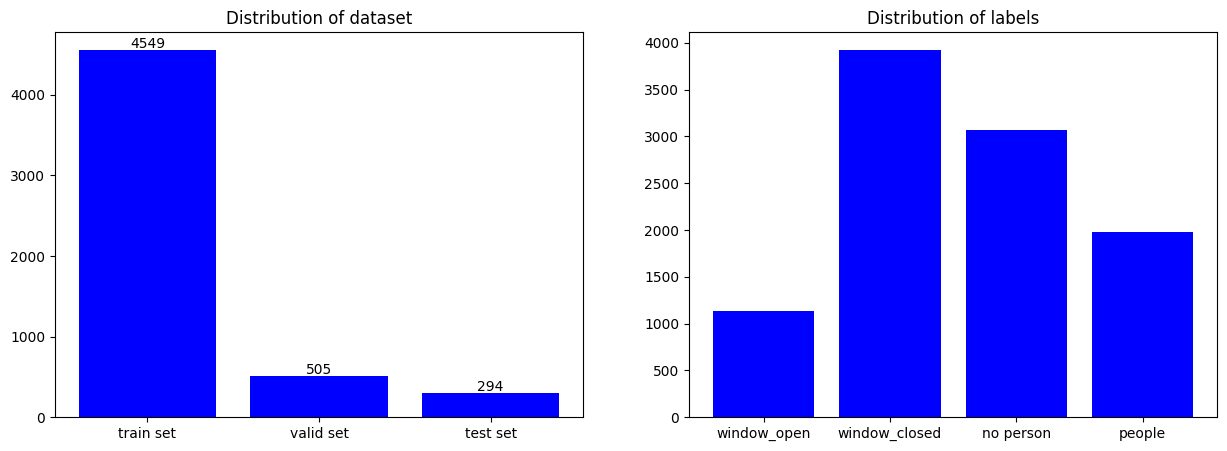

In [113]:

x_lbs = ['train set','valid set','test set']
y_nmrs = [x_train.shape[0],x_valid.shape[0],x_test.shape[0]]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))    
ind = np.arange(len(y_nmrs))  # the x locations for the groups
bars = ax1.bar(ind, y_nmrs, color="blue")
ax1.set_xticks(ind)
ax1.set_xticklabels(x_lbs, minor=False)
ax1.set_title('Distribution of dataset')
# plt.xlabel('x')
# plt.ylabel('y')
ax1.bar_label(bars)

y_df = pd.DataFrame(y)
y_df.columns = ['person','window_open']
x_lbs = ['window_open','window_closed','no person','people']
y_nmrs = [y_df['window_open'].value_counts()[1],y_df['window_open'].value_counts()[0],y_df['person'].value_counts()[0],y_df['person'].value_counts()[1]]

# fig, ax = plt.subplots(figsize=(10,5))    
ind = np.arange(len(y_nmrs))  # the x locations for the groups
bars = ax2.bar(ind, y_nmrs, color="blue")
ax2.set_xticks(ind)
ax2.set_xticklabels(x_lbs, minor=False)
ax2.set_title('Distribution of labels')
# plt.xlabel('x')
# plt.ylabel('y')
ax.bar_label(bars)

plt.show()


**tsai LEARNER**

read config file

In [114]:
with open('config.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)

epochs = hyperparams['model']['epochs']
bs = hyperparams['model']['bs']
num_workers = hyperparams['model']['num_workers']
embed_size = hyperparams['model']['embed_size']

**get pretrained encoder**

In [64]:
#for pure lstm
# import  archs_lstm_autoencoder 
# pretrained_dict = torch.load(f'models/{AutoEncoder.__name__}_{seq_len}_lstm.pt')
# new_autoencoder = archs_lstm_autoencoder.AutoEncoder(x_train.shape[1])

pretrained_dict = torch.load(f'models/{AutoEncoder.__name__}_{seq_len}_shuffled_{embed_size}.pt')
new_autoencoder = AutoEncoder(x_train.shape[1],embed_size=embed_size)

new_autoencoder.load_state_dict(pretrained_dict)
### get ptrtrained encoder
enc = new_autoencoder.encoder

**Train [note freezing the encoder before fitting]**

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.623968,0.603920,0.692079,00:00
1,0.587938,0.575303,0.692079,00:00
2,0.566159,0.552989,0.692079,00:00
3,0.542630,0.528247,0.693069,00:00
4,0.509986,0.501909,0.729703,00:00
5,0.479692,0.476644,0.739604,00:00
6,0.459716,0.458083,0.809901,00:00
7,0.439232,0.431553,0.798020,00:01
8,0.426815,0.412350,0.815842,00:00
9,0.403230,0.395612,0.819802,00:00


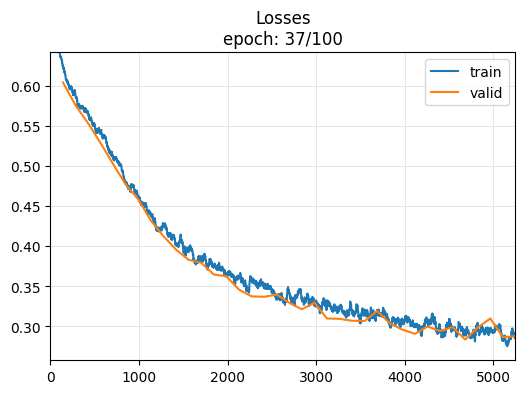

No improvement since epoch 32: early stopping


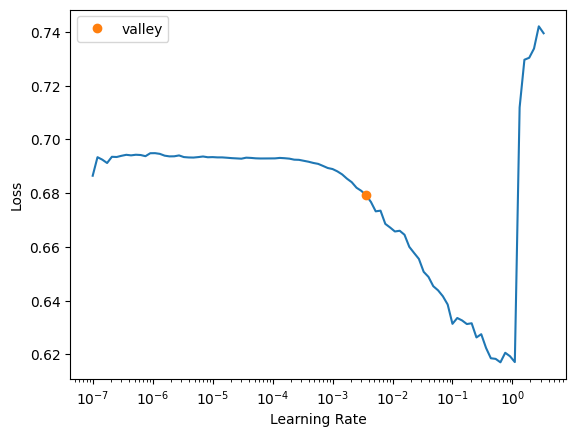

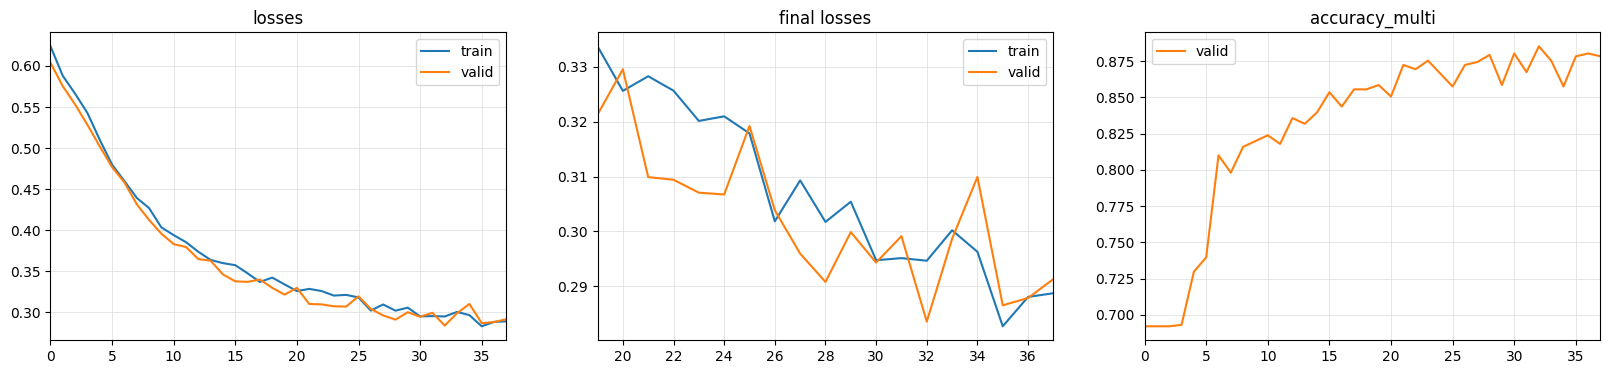

time= 43.87890863418579
No. of trainable parameters= 1902
train loss = 0.28873375058174133, valid loss = 0.29132458567619324
FlattenedLoss of BCEWithLogitsLoss()


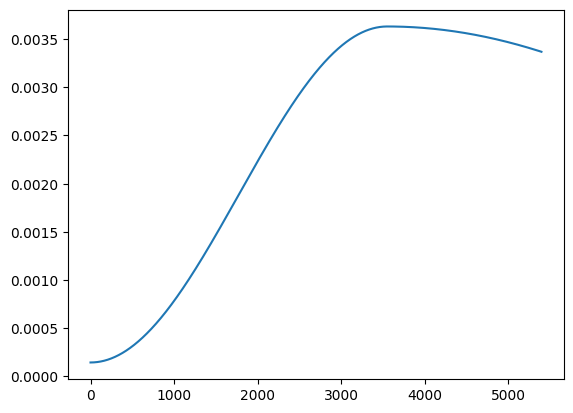

In [65]:
######## remove sigmoid from the network*****************

# splits = TimeSplitter()(y)
# tfms  = [None, Categorize()] ## single label
tfms  = [None, MultiCategorize()] ## multi label
batch_tfms = TSStandardize()

## single label
# tsets = TSDatasets(x_train, y_train[:,0], tfms=tfms, inplace=True)
# vsets = TSDatasets(x_valid, y_valid[:,0], tfms=tfms, inplace=True)
## multi label
tsets = TSDatasets(x_train, y_train, tfms=tfms, inplace=True)
vsets = TSDatasets(x_valid, y_valid, tfms=tfms, inplace=True)
######################
dls   = TSDataLoaders.from_dsets(tsets, vsets, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization

#### use batch normalization instead
# dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs = 32, num_workers=2,batch_tfms=batch_tfms) ### note the normalization

# k={'shuffle':False} ## for LSTM_FCN
# k={'layers':[16,16,16],'kss':[7,5,3]}
#############################################################
# k = {'hidden_size':22,'rnn_dropout':0.4}
# network = 'LSTM'
# k={'layers':[32,8]}
# network = 'FCN'
k={'encoder':enc,'n_neurons':100, 'embed_size':embed_size}
network = 'EncoderClassifier'
model = create_model(EncoderClassifier, dls.vars,dls.c,dls,**k)
# learn = Learner(dls, model, metrics=accuracy,cbs = ShowGraph()) ### single label
#### note the accuracy_multi and MultiCategorize() contains BCEwithlogits not normal BCE
learn = Learner(dls, model, metrics=accuracy_multi,cbs = ShowGraph()) ### multi label
##########################################################################3

freeze(learn)  #### freeze encoder

###########################################################################
start = time.time()
learn.fit_one_cycle(epochs,learn.lr_find().valley,cbs = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=5)) ## learning rate annealing
elapsed = time.time()-start
print(f'time= {elapsed}')
print(f'No. of trainable parameters= {count_parameters(model)}')
print(f'train loss = {learn.recorder.values[-1][0]}, valid loss = {learn.recorder.values[-1][1]}')
plt.figure()
plt.plot(learn.recorder.lrs)

print(learn.loss_func)
metrics = np.array(learn.recorder.values)

# save the model as state dictionary 
torch.save(learn.model.state_dict(), f'models/{learn.model._get_name()}.pt')
#### unfreeze encoder
unfreeze(learn) 
##### save and load pkl model
# learn.export('models/learn.pkl')
# learn = load_learner('models/learn.pkl')

**get train loss, valid loss and accuracy**

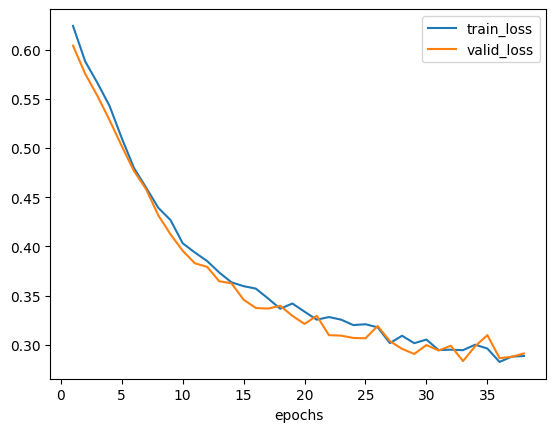

In [66]:
plt.figure()
xx = range(1,learn.epoch+2) ### epochs number after early stopping
plt.plot(xx,metrics[:,0],label='train_loss')
plt.plot(xx,metrics[:,1],label = 'valid_loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

**EVALUATION ON TEST DATA SET + Using PR curves**

In [130]:
# tfms  = [None, MultiCategorize()] ## multi label
# batch_tfms = TSStandardize()

# ## single label
# # tsets = TSDatasets(x_train, y_train[:,0], tfms=tfms, inplace=True)
# # vsets = TSDatasets(x_valid, y_valid[:,0], tfms=tfms, inplace=True)
# ## multi label
# tsets = TSDatasets(x_train, y_train, tfms=tfms, inplace=True)
# vsets = TSDatasets(x_valid, y_valid, tfms=tfms, inplace=True)
# ######################
# dls   = TSDataLoaders.from_dsets(tsets, vsets, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization

# # k={'layers':[32,8]}
# # network = 'FCN'

# k = {'hidden_size':22,'rnn_dropout':0.4}
# network = 'LSTM'
# #### load part of the pre trained model

# # load 
# pretrained_dict = torch.load(f'models/MyLSTM.pt')
# model = create_model(MyLSTM, dls.vars,dls.c,dls,**k)
# model.load_state_dict(pretrained_dict)

# # learn = Learner(dls, model, metrics=accuracy,cbs = ShowGraph()) ### single label
# #### note the accuracy_multi and MultiCategorize() contains BCEwithlogits not normal BCE
# learn = Learner(dls, model, metrics=accuracy_multi,cbs = ShowGraph()) ### multi label

Accuracy [Both]: 94.89796
Accuracy [person]: 97.95918
Accuracy [window_open]: 96.93877


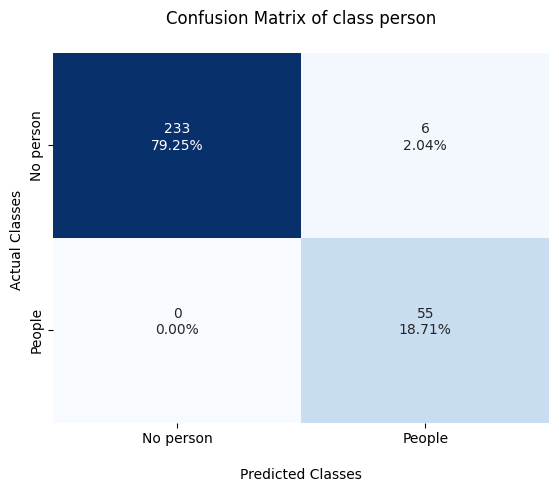

F1 score: 0.9482758620689655

precision: 0.9016393442622951

recall: 1.0



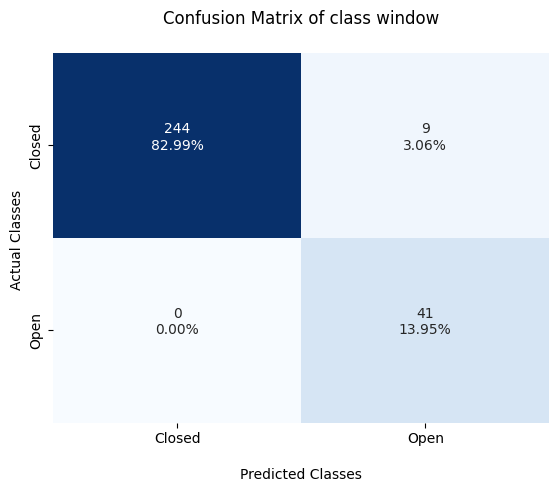

F1 score: 0.9010989010989011

precision : 0.82

recall : 1.0



In [131]:
#### Adding dataset to apply same dls valid tfms on test

### standardize test set with train parameters (apply Multicategorize transform)
test_set = TSDatasets(x_test, y_test, tfms=tfms, inplace=True) # multi_label
# test_set = TSDatasets(x_test, y_test[:,0], tfms=tfms, inplace=True) # single_label
test_dl   = TSDataLoader(test_set, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization
# next(iter(test_dl))
 
# apply transforms as in valid data set, but each with its own parameters
# test_ds = dls.valid.dataset.add_test(X[splits[2]], y[splits[2]]) #X and y would be your test data (segmented)
# test_dl = dls.valid.new(test_ds)
# next(iter(test_dl))

#### evaluating

test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,with_decoded=True)#,reorder = False)
test_preds = test_preds.long() ### to convert bool to int

###############################################################################################
###### use PR curve to get best threshold for each class on given test set
##############################################################################################
# # # class person
# # threshold_person, _ = plot_PR_curve('person',test_targets[:,0],test_probas[:,0])
# # ### class window_open
# # threshold_window, _ =plot_PR_curve('window',test_targets[:,1],test_probas[:,1])
# threshold_person,threshold_window = plot_PR_curve_both(test_targets,test_probas)
# test_preds[:,0] = (test_probas[:,0]>=threshold_person)
# test_preds[:,1] = (test_probas[:,1]>=threshold_window)
#################################################################################################

## single label
### number of classes in validation set
# n_classes = pd.DataFrame(test_targets).value_counts().shape[0]
# plot_confusion(test_targets,test_preds,n_classes,name = 'person')
# print(f'Accuracy: {(test_targets == test_preds).float().mean():0.5f}')  
# print(f'F1 score: {f1_score(test_targets,test_preds)}\n') # to get f1 score for each class use (average=None)
# print(f'precision: {precision_score(test_targets,test_preds)}\n') 
# print(f'recall: {recall_score(test_targets,test_preds)}\n') 

## multi label
print(f'Accuracy [Both]: {(100/test_targets.shape[0])*torch.all((test_preds == test_targets),dim=1).sum():0.5f}') ## multi-label
print(f'Accuracy [person]: {(100/test_targets.shape[0])*(test_preds[:,0] == test_targets[:,0]).sum():0.5f}') ## multi-label
print(f'Accuracy [window_open]: {(100/test_targets.shape[0])*(test_preds[:,1] == test_targets[:,1]).sum():0.5f}') ## multi-label
n_classes = test_targets.shape[1]

## person class
plot_confusion(test_targets[:,0],test_preds[:,0],n_classes,name = 'person')
print(f'F1 score: {f1_score(test_targets[:,0],test_preds[:,0])}\n')
print(f'precision: {precision_score(test_targets[:,0],test_preds[:,0])}\n') 
print(f'recall: {recall_score(test_targets[:,0],test_preds[:,0])}\n') 

### window class
plot_confusion(test_targets[:,1],test_preds[:,1],n_classes,name = 'window')
print(f'F1 score: {f1_score(test_targets[:,1],test_preds[:,1])}\n') 
print(f'precision : {precision_score(test_targets[:,1],test_preds[:,1])}\n') 
print(f'recall : {recall_score(test_targets[:,1],test_preds[:,1])}\n') 


**new metric based on weighted normalized kullback leibler divergence**

In [132]:
### person class
p = test_preds[:,0]
t = test_targets[:,0]
kl_score_person = ((normalized_kl(t,p) + normalized_kl(p, t))/2).item() ## to be symmetric
### window class
p = test_preds[:,1]
t = test_targets[:,1]
kl_score_window = ((normalized_kl(t,p) + normalized_kl(p, t))/2).item() ## to be symmetric
print (f'kl_score for person class= {kl_score_person} \n kl_score for window class= {kl_score_window}') 

kl_score for person class= 0.9640987515449524 
 kl_score for window class= 0.9333946108818054


**investigate distribution of wrong predictions** 

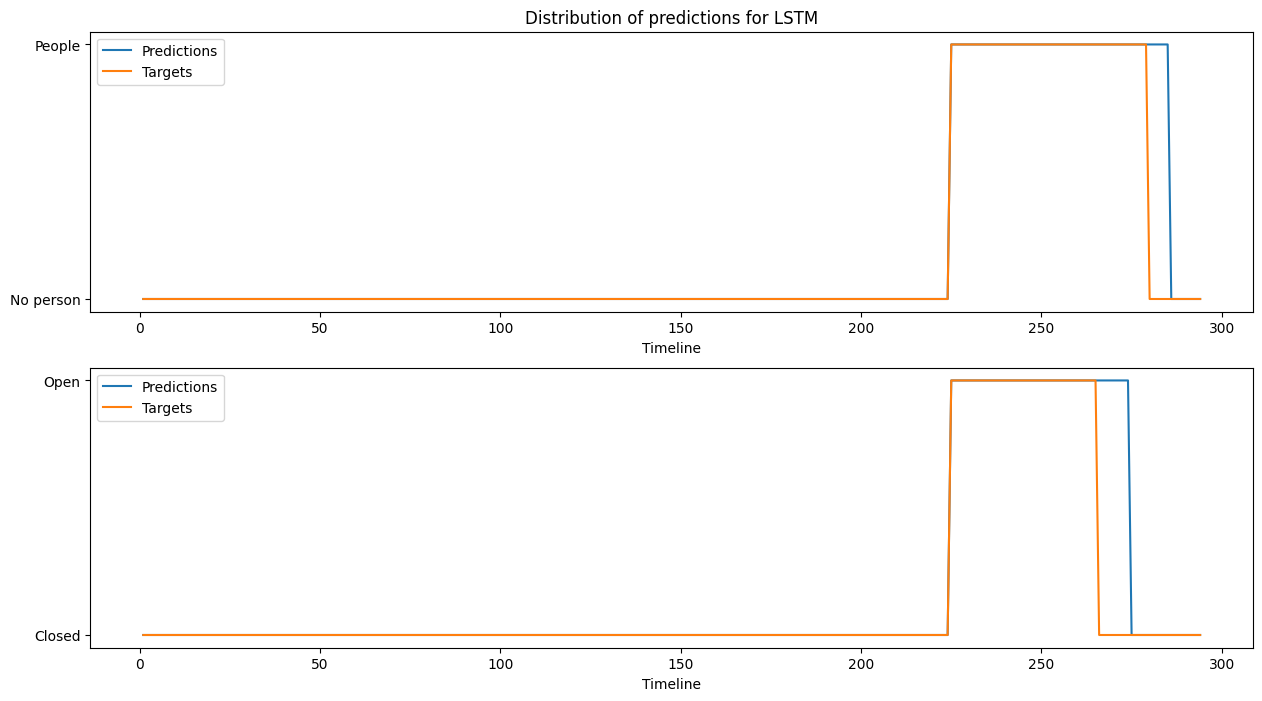

In [134]:
#### single label
# ## plot targets vs predictions person
# plot_distribution(test_targets,test_preds,'person')
# ## plot FP, FN 
# plot_fp_fn(test_targets,test_preds,'person')


#### multi label
plot_distribution_both(test_targets,test_preds, network)

## plot targets vs predictions person
# plot_distribution(test_targets[:,0],test_preds[:,0],'person')
## plot FP, FN 
# plot_fp_fn(test_targets[:,0],test_preds[:,0],'person')

## plot targets vs predictions window
# plot_distribution(test_targets[:,1],test_preds[:,1],'window')
## plot FP, FN 
# plot_fp_fn(test_targets[:,1],test_preds[:,1],'window')


**visualizing features in a lower dimensional space [note output of encoder]**

load unannotaed data for visualization in latent space of classifier

In [69]:
### loading data

csv_file = '~/data/df_limit_large_clean.csv'
if all_features:
    cols =['pressure','temperature','sound','tvoc','oxygen','humidity','humidity_abs','co2','co','so2','no2','o3','pm2_5','pm10','pm1','sound_max','dewpt']
else:
    cols = f_.copy()
cols.extend(['deviceid_int','datetime','deviceid'])
df_chunks = pd.read_csv(csv_file, usecols =cols)#,chunksize=100000)
n_features = len(f_)

device_ids = df_chunks['deviceid_int'].unique()

device_num = device_ids[0]
device_id = df_chunks.loc[df_chunks['deviceid_int'] == device_ids[device_num]]['deviceid'][0]
df_chunks = df_chunks.drop(columns=['deviceid'])

df_unannotated = (df_chunks.loc[df_chunks['deviceid_int'] == device_ids[device_num]]).drop(columns=['deviceid_int']) [:500]#[5500:6000]
datetime_column = df_unannotated['datetime']
df_unannotated = df_unannotated.drop(columns=['datetime'])
### test set
x_unannotated_ = sliding(seq_len,stride,df_unannotated,mode=sliding_mode)


#### standardization
x_test_unannotated = np.zeros(x_unannotated_.shape,dtype=np.float32)
for i in range(x_test_unannotated.shape[1]): ## n_features
    x_test_unannotated[:, i, :] = scalers[i].transform((x_unannotated_)[:, i, :].reshape(-1,1)).reshape(x_test_unannotated.shape[0],x_test_unannotated.shape[-1]) ## test set from outside

##### testing dataloaders
y_test_unannotated = np.zeros(x_test_unannotated.shape[0],dtype = np.float32)

#####for PREDICTION IN AUTOENCODER WITHOUT TRUE TARGETS
test_set = TSDatasets(x_test_unannotated, inplace=True) 
test_dl_unannotated = TSDataLoader(test_set, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization


predict for encoder classifier on unannotated data without true labels

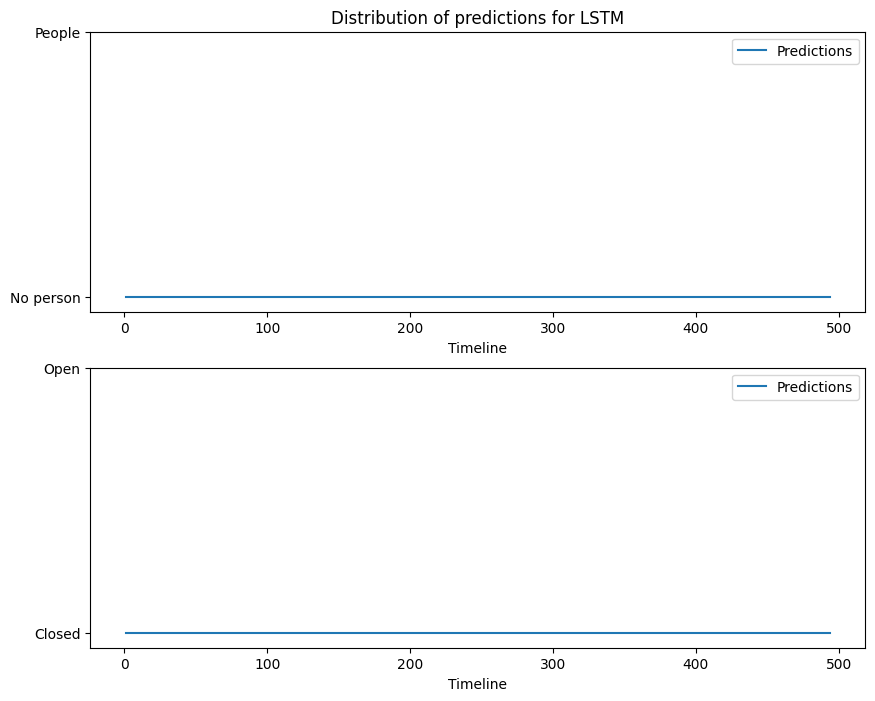

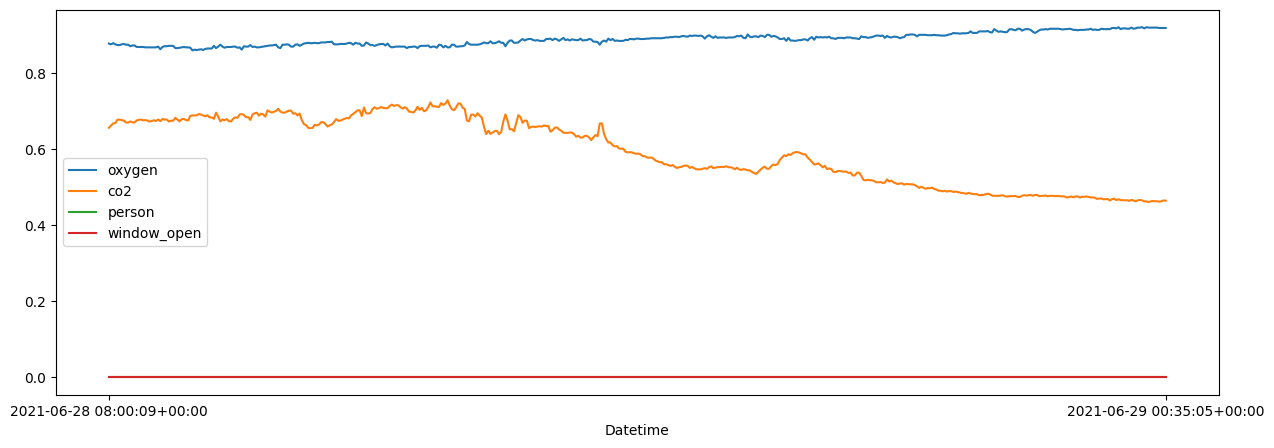

In [72]:
### get encoderclassifier
# pretrained_dict = torch.load(f'models/{EncoderClassifier.__name__}.pt')
# k={'encoder':enc,'n_neurons':100, 'embed_size':embed_size}
# new_autoencoder = create_model(EncoderClassifier, dls.vars,dls.c,dls,**k)
# network = 'EncoderClassifier'

### get LSTM
pretrained_dict = torch.load(f'models/{MyLSTM.__name__}.pt')
k = {'hidden_size':22,'rnn_dropout':0.4}
new_autoencoder = create_model(MyLSTM, dls.vars,dls.c,dls,**k)  ## LSTM
network = 'LSTM'
### get FCN
# pretrained_dict = torch.load(f'models/{MyFCN.__name__}.pt')
# k={'layers':[32,8]}
# new_autoencoder = create_model(MyFCN, dls.vars,dls.c,dls,**k)  ## FCN
# network = 'FCN'

##################################################
new_autoencoder.load_state_dict(pretrained_dict)

###
new_autoencoder.to(device)
new_autoencoder.eval()
feats = []
lbls = []
with torch.no_grad():
    for inputs in test_dl_unannotated:
        inputs = inputs[0].to(device)
        outputs = new_autoencoder(inputs)
        feats.append(outputs) #### for output of encoder


test_probas_unannotated = torch.cat(feats).detach().cpu().numpy()
test_probas_unannotated = torch.sigmoid(torch.from_numpy(test_probas_unannotated)) ### cause output of classifier is logits not probas
test_preds_unannotated = np. zeros(test_probas_unannotated.shape)  ### for predictions
### change the threshold
# threshold_person = 0.5
# threshold_window = 0.5
# test_preds_unannotated[:,0] = (test_probas_unannotated[:,0]>threshold_person)
# test_preds_unannotated[:,1] = (test_probas_unannotated[:,1]>threshold_window)

### plot predictions
plot_distribution_both(None,test_preds_unannotated,network)
# plot_distribution(None,test_preds_unannotated[:,0],'person')
# plot_distribution(None,test_preds_unannotated[:,1],'window')

n_seq = x_test_unannotated.shape[0]
x = datetime_column.iloc[0:n_seq]

df_cropped = df_unannotated.iloc[0:n_seq]


fig = plt.figure(figsize=(15,5))
plt.xlabel('Datetime')
plt.plot(x, df_cropped['oxygen']-20,label='oxygen')
plt.plot(x, df_cropped['co2']/1000,label='co2')
plt.plot(x, test_preds_unannotated[:,0],label='person')
plt.plot(x, test_preds_unannotated[:,1], label='window_open' )
plt.xticks([0,n_seq-1])
plt.legend()


visualizing embedding space [note: test data for unannotated &&& output of encoder]

In [90]:
##### testing dataloaders
tfms  = [None, MultiCategorize()] ## multi label
test_set = TSDatasets(x_test, y_test, tfms=tfms, inplace=True) # multi_label
test_dl   = TSDataLoader(test_set, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization

### for VISUALIZATION unannotated data WITH SUPERVISED DATA FCN, LSTM, ...
# tfms  = [None, Categorize()] ## single label
# test_set = TSDatasets(x_test_unannotated, y_test_unannotated, tfms=tfms, inplace=True) 
# test_dl_unannotated = TSDataLoader(test_set, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization

###############################
#### creating only body of the network for lstm,fcn
################################################
# k_lstm = {'c_in':x_train.shape[1],'c_out':y_train.shape[1],'hidden_size':22,'rnn_dropout':0.4}
# k_fcn={'c_in':x_train.shape[1],'c_out':y_train.shape[1],'layers':[32,8]}
# # new_model = create_model(LSTM_body, dls.vars,dls.c,dls,**k)

# # new_model = LSTM_body(**k_lstm)  ## LSTM
# # network = 'LSTM'

# new_model = MyFCN_body(**k_fcn)    ## MyFCN
# network = 'FCN'

# #### load part of the pre trained model

# # load 
# pretrained_dict = torch.load(f'models/{learn.model._get_name()}.pt')
# # pretrained_dict = torch.load(f'models/MyLSTM.pt')
# model_dict = new_model.state_dict()
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# new_model.load_state_dict(model_dict)
#######################################################

new_model = enc ##### for encoder_classifier
network = 'AutoEncoder'

###########################################
###### get the features/predicions of the model_body
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

new_model.to(device)
new_model.eval()
feats = []
lbls = []
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = new_model(inputs)
        #####################################################
        feats.append(outputs[:,-1]) #### for output of encoder
        #######################################################
        # feats.append(outputs)  ### for lstm, fcn
        #######################################################
        lbls.append(labels)

test_lbls = torch.cat(lbls).detach().cpu().numpy()
test_feats = torch.cat(feats).detach().cpu().numpy()

## for unannotated data
# feats = []
# lbls = []
# with torch.no_grad():
#     for inputs, labels in test_dl_unannotated:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = new_model(inputs)
#         #####################################################
#         # feats.append(outputs[:,-1]) #### for output of encoder
#         #######################################################
#         feats.append(outputs)  ### for lstm, fcn
#         #######################################################
#         lbls.append(labels)

# test_lbls_unannotated = torch.cat(lbls).detach().cpu().numpy()
# test_feats_unannotated = torch.cat(feats).detach().cpu().numpy()

# ### get labels as strings
# ## for unannotated data
# unannotated_labels = ['unannotated' for i in range(test_lbls_unannotated.shape[0])]
### for annotated
person_labels = []
person_dict = {1 : 'people', 0 : 'no person'}
window_labels = []
window_dict = {1 : 'open', 0 : 'closed'}
for item in test_lbls:
    person_labels.append(person_dict[item[0]])
    window_labels.append(window_dict[item[1]])

##########
# using tensorboard projector
# writer = SummaryWriter('runs/')
# writer.add_embedding(test_feats,metadata=person_labels,tag = f'person_embeddings_{learn.model._get_name()}')
# writer.add_embedding(test_feats,metadata=window_labels,tag = f'window_embeddings_{learn.model._get_name()}')
# writer.close()
##########
### using sklearn and plotly
### for annotated
components = visualize_embeddibgs(network,test_feats,person_labels,window_labels,n_components=2,method='pca')
### for annotated+ununnotated
# components = visualize_embeddibgs(network,test_feats,person_labels,window_labels,test_feats_unannotated,unannotated_labels,combined=True,n_components=2,method='pca')

**Merge images**

In [93]:
#Read the two images
path = '/afs/tu-chemnitz.de/home/urz/a/abom/internship/graphs/'
image1 = Image.open(path+'pcaPerson.png')
image2 = Image.open(path+'pcaWindow.png')
#resize, first image
# image2 = image2.resize(image1.size)
image1_size = image1.size
image2_size = image2.size
new_image = Image.new('RGB',(image1_size[0], 2* image1_size[1]-40))
new_image.paste(image1,(0,0))
new_image.paste(image2,(0,image1_size[1]-40))
new_image.save(path+f"pca{network}.png","PNG")


**optuna for HP optimization**

load yaml file

In [ ]:
with open('config.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)

optimize (notice freeze for autoencoder)

In [ ]:
epochs = hyperparams['optuna']['epochs']
optuna_trials = hyperparams['optuna']['trials']
bs = hyperparams['model']['bs']
num_workers = hyperparams['model']['num_workers']

tfms  = [None, MultiCategorize()] 
batch_tfms = TSStandardize()


tsets = TSDatasets(x_train, y_train, tfms=tfms, inplace=True)
vsets = TSDatasets(x_test, y_test, tfms=tfms, inplace=True)
dls   = TSDataLoaders.from_dsets(tsets, vsets, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization


def objective(trial:optuna.Trial):
    # Define search space here. Supported search space are 
    
    # filters_1 = trial.suggest_int('filters_1',8,32,step = 4) 
    # filters_2 = trial.suggest_int('filters_2',8,32,step = 4) 
    # rnn_dropout = trial.suggest_float("rnn_dropout", 0.1, 0.5, step = 0.1)
    # hidden_size = trial.suggest_int('hidden_size',10,30,step = 2)
    
    # n_filters = trial.suggest_categorical('num_filters', [8,16,24,32]) 
    # lr = trial.suggest_float("Learning_rate", 1e-8, 1e-6, log=True)
    # k={'fc_dropout': dropout_rate}

    # k = {'hidden_size':hidden_size,'rnn_dropout':rnn_dropout}
    # k={'layers':[filters_1,filters_2]}
    n_filters = trial.suggest_int('num_filters',50,150,step = 10)
    k={'encoder':enc,'n_neurons':n_filters}
    model = create_model(EncoderClassifier, dls.vars,dls.c,dls,**k)
    #### note the F1_multi and MultiCategorize() contains BCEwithlogits not normal BCE
    learn = Learner(dls, model, metrics=F1_multi)
    ####################################
    freeze(learn) #### for autoencoder
    ######################################
    learn.fit_one_cycle(epochs,learn.lr_find().valley) ## learning rate annealing
            
    # return the F1 score - learn.recorder.values returns [[train_loss, valid_loss, F1_multi]]
    return learn.recorder.values[-1][-1]

    # return the valid_loss - learn.recorder.values returns [[train_loss, valid_loss, acc]]
    # return learn.recorder.values[-1][1]

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=optuna_trials, show_progress_bar=False)

In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  14
Best trial:
  Value:  0.16657622158527374
  Params: 
    num_filters: 100


**Benchmarking**

In [ ]:
dsid = 'LSST' 

tfms  = [None, MultiCategorize()] 
batch_tfms = TSStandardize()
tsets = TSDatasets(x_train, y_train, tfms=tfms, inplace=True)
vsets = TSDatasets(x_valid, y_valid, tfms=tfms, inplace=True)
dls   = TSDataLoaders.from_dsets(tsets, vsets, bs = 32, num_workers=2)#,batch_tfms=batch_tfms) ### note the normalization


archs = [(FCN, {}), 
         (LSTM, {'n_layers':1, 'bidirectional': False}), 
         (LSTM, {'n_layers':1, 'bidirectional': True}),
         (InceptionTime, {})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch,dls.vars,dls.c, dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy_multi)
    start = time.time()
    learn.fit_one_cycle(10, learn.lr_find().valley)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    display(results)

**calculate time**

In [ ]:
import timeit

start = timeit.default_timer()



 
learn = TSClassifier(X, y, splits=splits, lr=1e-5,path='models', arch=LSTMPlus , batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(10)
stop = timeit.default_timer()

print('Time: ', stop - start) 

**test custom torch datasets and dataloaders**

In [ ]:
# ds = MyDataSet(X,y,transform=ToTensor())
# bs = 32

# splits = TrainValidTestSplitter()(y)

# tsets = MyDataSet(X[splits[0]], y[splits[0]])#, transform=tfms) #train dataset
# vsets = MyDataSet(X[splits[1]], y[splits[1]])#, transform=tfms) #valid dataset

# tls = DataLoader(tsets, batch_size=bs, shuffle=False, num_workers=2)
# vls = DataLoader(vsets, batch_size=bs, shuffle=False, num_workers=2)
# classes = ('person','window_open')


**Train**

In [ ]:
# # model = ConvNet(X.shape[1],y.shape[1]).to(device)

#standardize train set, then use params to standardize valid and test
# for MyLearner this is done internally

### standardization using my functions
# x_train,p1,p2 = standardize(X[splits[0]],mode=1)
# x_valid = standardize_with_params(X[splits[1]],mean=p1,std=p2)



model = MyFCN(X.shape[1],y.shape[1])
learn = MyLearner(x_train,y_train,x_valid,y_valid,model) #### normalize
learn.fit(30)

# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)



**evaluate on test data**

In [ ]:
learn.eval(x_test,y_test)

**SMOTE Oversampling (destroys the time series !!!)**

In [ ]:
# from imblearn.over_sampling import SMOTE,KMeansSMOTE
# from sklearn.model_selection import train_test_split

# ##### NOTE THE SHUFFLE AND TIME SERIES
# x_train, x_valid, y_train, y_valid = train_test_split(df_mini.iloc[:,0:-1], df_mini.iloc[:,-1], test_size=0.2, shuffle=False)

# print(y_train.value_counts())
# ### get array of dataset train and target

# # train = to_np(dsets.train[:][0])
# # tar = to_np(dsets.train[:][1])
# # print(tar.shape,train.shape)


# ### Apply SMOTE only on train dataset to avoid data leakage
# sm = SMOTE(random_state=42,sampling_strategy={1:20000,2:10000})

# x_res, y_res = sm.fit_resample(x_train, y_train)
# print(y_res.value_counts())

# ### create sliding windows
# x_train,y_train = sliding(window,stride,x_res,y_res)
# x_valid,y_valid = sliding(window,stride,x_valid,y_valid)
# print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

